<span style="color: red; font-size: 2em; font-weight: bold;">Example 6: (Solar_Wind +Storage Unit) - Load - Backup Generator </span>

Network Connections:
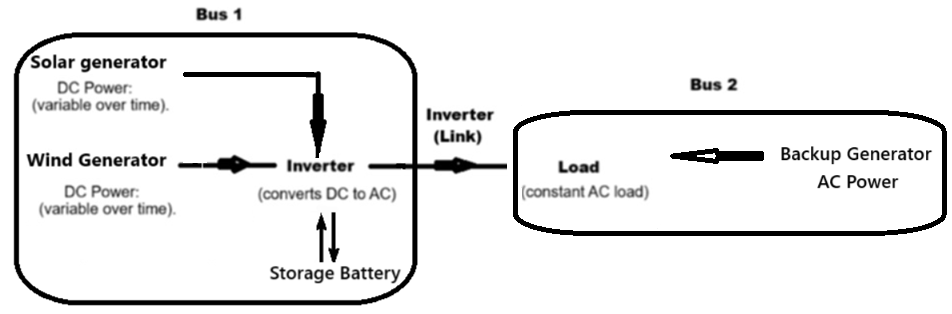

In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar and wind generators to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)


# Add Solar Generator
solar_profile = pd.Series([0, 0, 0, 0, 0, 0.1, 0.3, 0.6, 0.8, 0.9, 1, 0.95, 0.9, 0.85, 0.7, 0.5, 0.3, 0.1, 0, 0, 0, 0, 0, 0], index=hours)
p_nom_solar = 150  # Nominal power (MW)
network.add("Generator", "Solar Generator", bus="bus1", p_nom=p_nom_solar, p_max_pu=solar_profile, carrier="solar")

# Add Wind Generator
wind_profile = pd.Series([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.95, 1, 0.98, 0.96, 0.93, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35], index=hours)
p_nom_wind = 150  # Nominal power (MW)
network.add("Generator", "Wind Generator", bus="bus1", p_nom=p_nom_wind, p_max_pu=wind_profile, carrier="wind")


# Add Storage Unit
network.add("StorageUnit", "Battery Storage", bus="bus1", p_nom=200, max_hours=4, efficiency_store=0.9, efficiency_dispatch=0.9, state_of_charge_initial=400, carrier="battery")


# Add Inverter
network.add("Link", "Inverter", bus0="bus1", bus1="bus2", p_nom=p_nom_solar * 2, efficiency=0.95, carrier="inverter")

# Add Backup Generator (Diesel)
network.add("Generator", "Backup Generator", bus="bus2", p_nom=100, efficiency=0.4, marginal_cost=50, carrier="diesel")


# Define constant load demand
p_load = 200  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)
network.add("Load", "Load", bus="bus2", p_set=load_demand)

# Solve the network
network.lopf(network.snapshots)

# Extract results
wind_generation = wind_profile * p_nom_wind * inverter_efficiency
solar_generation = solar_profile * p_nom_solar * inverter_efficiency
storage_dispatch = network.storage_units_t.p["Battery Storage"]
storage_charging = storage_dispatch.clip(upper=0)
storage_discharging = storage_dispatch.clip(lower=0)
backup_generation = network.generators_t.p["Backup Generator"]
total_generation = wind_generation + solar_generation + backup_generation
total_to_load = total_generation + storage_dispatch

# Plot 1: Load and Power Generation
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.plot(hours, backup_generation, label="Backup Generator (MW)", color="red", linestyle="--", linewidth=2)
plt.title("Load and Power Generation", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Charging and Discharging
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load (Wind + Solar + Storage + Backup)
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, total_generation, label="Total Generation (Wind + Solar + Backup) (MW)", color="purple", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Solar + Storage + Backup Contribution to Load (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind, Solar, Storage, and Backup Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


<span style="color: red; font-size: 2em; font-weight: bold;">Step by step code</span>

# Step 1: Setting Up the Environment

## Install PyPSA

In [ ]:
#!pip install pypsa

In [1]:
# Import pypsa 
import pypsa

## Additional Libraries
PyPSA may require other libraries for plotting and numerical operations:

In [2]:
# pip install numpy pandas matplotlib networkx

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Creating Your Network:

## Creating the Network

In [4]:
# Create an empty network
network = pypsa.Network()

Network: Represents the electrical network.

## Add buses

In [5]:
# Add 2 buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar and wind generators to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
bus1,1.0,,0.0,0.0,DC,,1.0,0.0,inf,PQ,
bus2,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,


Bus: A bus represents a point in the system where power is injected or consumed. It’s where all electrical components (load, generator) connect.

v_nom: This is the nominal voltage of the bus. For simplicity, we set it to 20 kV.

## Define time steps for the simulation

In [6]:
# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)
hours

# hours = range(24)
# network.set_snapshots(hours)
# hours

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

## Add Generators:

### Add a Solar Generator

In [7]:
# Generate solar profile
solar_profile = pd.Series([0, 0, 0, 0, 0, 0.1, 0.3, 0.6, 0.8, 0.9, 1, 0.95, 0.9, 0.85, 0.7, 0.5, 0.3, 0.1, 0, 0, 0, 0, 0, 0], index=hours)

In [8]:
# Add the solar generator to Bus 1 
p_nom_solar = 150  # Nominal power (MW)
network.add("Generator", 
            "Solar Generator", 
            bus="bus1", 
            p_nom=p_nom_solar, 
            p_max_pu=solar_profile, 
            carrier="solar")

# p_max_pu=wind_profile(%)*p_nom

### Add a Wind Generator

In [9]:
# Generate a wind profile
wind_profile = pd.Series([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.95, 1, 0.98, 0.96, 0.93, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35], index=hours)

In [10]:
# Add Wind Generator to Bus 1
p_nom_wind = 150  # Nominal power (MW
network.add("Generator", 
            "Wind Generator", 
            bus="bus1", 
            p_nom=p_nom_wind, 
            p_max_pu=wind_profile, 
            carrier="wind")

# The wind generator has internal rectifier that convert and smooth the power from AC to DC

### Add Backup Generator (Diesel)

In [11]:
# Connect the Backup Generator  directly to the load. 

network.add("Generator", 
            "Backup Generator", 
            bus="bus2", 
            p_nom=100, 
            efficiency=0.4, 
            marginal_cost=50, 
            carrier="diesel")

# The backup generator only operates when the total generation from solar, wind, and storage is insufficient to meet the load.
# Or when it is very expensive 

## Add Storage Unit

In [12]:
# Add Storage Unit
network.add("StorageUnit", 
            "Battery Storage", 
            bus="bus1", 
            p_nom=200, 
            max_hours=4, 
            efficiency_store=0.9, 
            efficiency_dispatch=0.9, 
            state_of_charge_initial=400, 
            carrier="battery")


## Add Inverter (as a link)

In [13]:
# Add Inverter (as a link) between Bus 1 (DC) and Bus 2 (AC)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter", 
            bus0="bus1", 
            bus1="bus2", 
            p_nom=p_nom_solar * 2, 
            efficiency=inverter_efficiency, 
            carrier="inverter")

            bus0="bus1"  # DC input
            bus1="bus2"  # AC output

## Add a Load
A load consumes power from the grid. Let’s add a load to Bus2 that will consume some power.

In [14]:
# Define constant load demand

p_load = 200  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)

network.add("Load", 
            "Load", 
            bus="bus2", 
            p_set=load_demand)


#network.add("Load", "Load", bus="bus2", p_set=[200]*24)  # 200 MW constant demand


Load: Represents a power consumer.

bus: The bus where the load is connected. # Connected to AC bus

p_set: Constant load demand (MW)

# Step 3: Check results

In [15]:
# Print the network
print(network)

PyPSA Network
Components:
 - Bus: 2
 - Generator: 3
 - Link: 1
 - Load: 1
 - StorageUnit: 1
Snapshots: 24


# Step 4: Solving the Network
PyPSA includes tools for solving network power flows and optimization problems.

## Power Flow Calculation
After setting up the network, calculate the power flow:
We will now solve the network to find the power flow, voltages at each bus, and the power transmitted through the lines.

In [16]:
# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.27s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.44e+04


('ok', 'optimal')

## Extract results

You can inspect the power flows on lines and outputs of generators:

In [17]:
# Extract results
wind_generation = wind_profile * p_nom_wind * inverter_efficiency
solar_generation = solar_profile * p_nom_solar * inverter_efficiency
storage_dispatch = network.storage_units_t.p["Battery Storage"]
storage_charging = storage_dispatch.clip(upper=0)
storage_discharging = storage_dispatch.clip(lower=0)
backup_generation = network.generators_t.p["Backup Generator"]
total_generation = wind_generation + solar_generation + backup_generation
total_to_load = total_generation + storage_dispatch


# Power Visualization

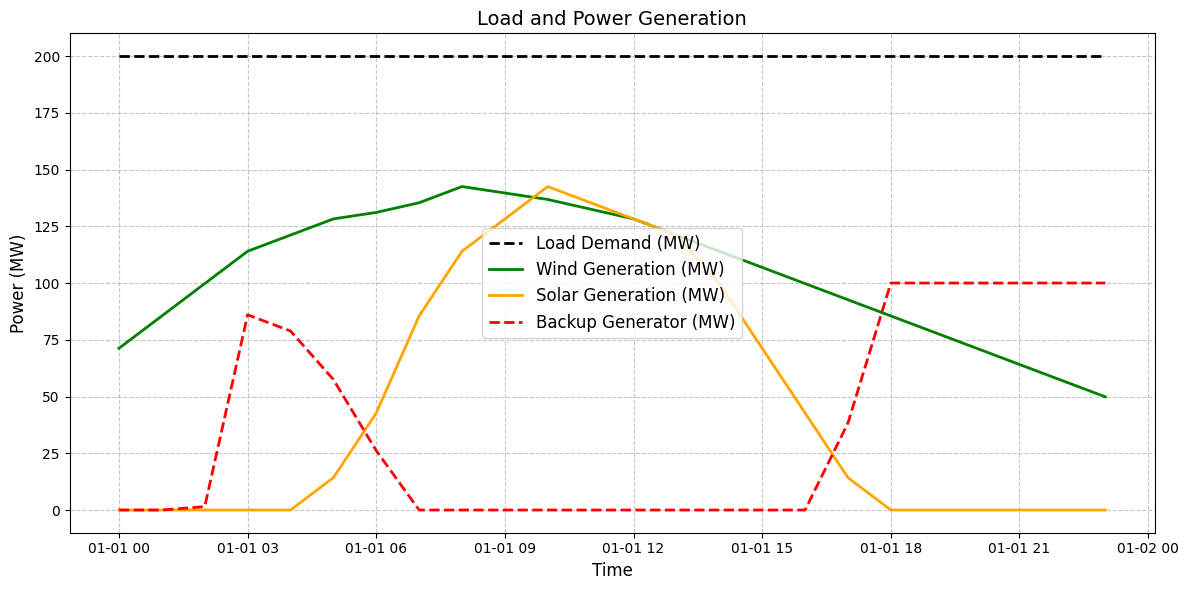

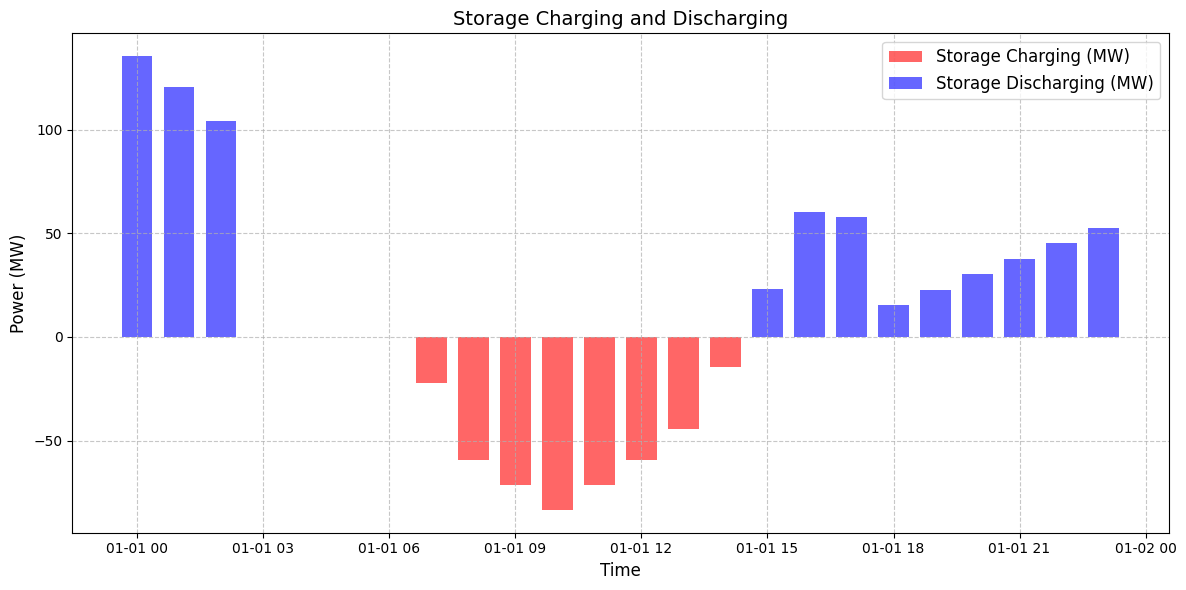

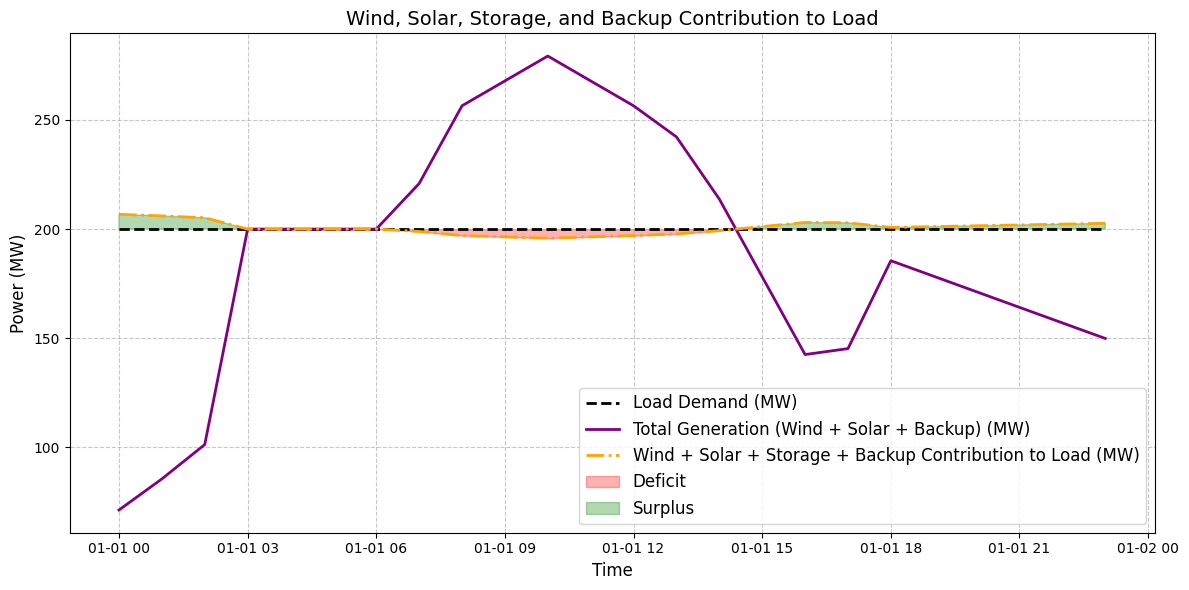

In [18]:
# Plot 1: Load and Power Generation
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, wind_generation, label="Wind Generation (MW)", color="green", linewidth=2)
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.plot(hours, backup_generation, label="Backup Generator (MW)", color="red", linestyle="--", linewidth=2)
plt.title("Load and Power Generation", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Storage Charging and Discharging
plt.figure(figsize=(12, 6))
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="blue", alpha=0.6, width=0.03)
plt.title("Storage Charging and Discharging", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Total Contribution to Load (Wind + Solar + Storage + Backup)
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand (MW)", color="black", linestyle="--", linewidth=2)
plt.plot(hours, total_generation, label="Total Generation (Wind + Solar + Backup) (MW)", color="purple", linewidth=2)
plt.plot(hours, total_to_load, label="Wind + Solar + Storage + Backup Contribution to Load (MW)", color="orange", linestyle="-.", linewidth=2)
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load < load_demand), interpolate=True, color="red", alpha=0.3, label="Deficit")
plt.fill_between(hours, total_to_load, load_demand, where=(total_to_load >= load_demand), interpolate=True, color="green", alpha=0.3, label="Surplus")
plt.title("Wind, Solar, Storage, and Backup Contribution to Load", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
